# Exploring Diversity in Schelling Model
## Modeling Complex Systems (CS/CSYS 6020), Fall 2024 
## Assignment 2
**Authors:** Jackson Lipfert, Michael Robinette, J. Franco, Rae Tiffen

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from time import sleep

In [54]:
# Grid dimensions
N1, N2 = 20, 20

# Initialization parameters
probability = 0.5  # Controls how many cells are occupied (vs empty)
ratio = 0.5  # Controls proportion of type 1 (blue) cells
granny_drummer_other_proportion = 0.1  # Ratio of grandmas and drummers versus normal active cells
g_to_d_ratio = 0  # Ratio of grandmas to drummers

# Effect parameters
grandma_effect = 0.5  # How much the grandma affects happiness of other agents
drummer_effect = 0.5  # How much the drummer affects happiness of other agents
happiness_threshold = 0.5

# Behavior flags
make_drummer_and_granny_static = True  # If True, drummers and grannies don't move

# Initialize grid
neighborhood = np.zeros((N1, N2), dtype=int)

def initialize_schelling_grid(neighborhood, probability, ratio, granny_drummer_other_proportion, g_to_d_ratio):
    empty = []
    active = []
    N1 = neighborhood.shape[0]
    N2 = neighborhood.shape[1]
    
    for i in range(N1):
        for j in range(N2):
            die = random.uniform(0, 1)
            
            if die < probability:  # Active cell
                die_type = random.uniform(0, 1)
                
                if die_type < granny_drummer_other_proportion:  # Special types (grandma/drummer)
                    die_type_special = random.uniform(0, 1)
                    if die_type_special < g_to_d_ratio:
                        neighborhood[(i, j)] = 3  # Grandmas
                        active.append((i, j))
                    else:
                        neighborhood[(i, j)] = 4  # Drummers
                        active.append((i, j))
                        
                elif die_type > granny_drummer_other_proportion:  # Normal types
                    die_type_normal = random.uniform(0, 1)
                    if die_type_normal < ratio:
                        neighborhood[(i, j)] = 1  # Type 1 (blue)
                        active.append((i, j))
                    else:
                        neighborhood[(i, j)] = 2  # Type 2 (red)
                        active.append((i, j))
            else:
                neighborhood[(i, j)] = 0  # Empty
                empty.append((i, j))
    
    return neighborhood, empty, active

def check_happiness(neighborhood, i, j, agent_type=None):
    if agent_type is None:
        current_type = neighborhood[i, j]
    else:
        current_type = agent_type
    
    # Can't check happiness for empty cells
    if current_type == 0:
        return False
    
    # Grandmas and drummers are always happy
    if current_type == 3 or current_type == 4:
        return True
    
    N1, N2 = neighborhood.shape
    neighbors = []
    
    # Define the 8 possible neighbor directions (including diagonals)
    directions = [
        (-1, -1), (-1, 0), (-1, 1),  # Top row
        (0, -1),           (0, 1),    # Same row (left and right)
        (1, -1),  (1, 0),  (1, 1)     # Bottom row
    ]
    
    # Collect all valid neighbors
    for di, dj in directions:
        neighbor_i = i + di
        neighbor_j = j + dj
        
        # Check if neighbor is within bounds
        # Is the neighbor's row index between 0 (inclusive) and N1 (exclusive)?
        # AND Is the neighbor's column index between 0 (inclusive) and N2 (exclusive)?  
        if 0 <= neighbor_i < N1 and 0 <= neighbor_j < N2:
            neighbors.append(neighborhood[neighbor_i, neighbor_j])
    
    same_type = sum(1 for n in neighbors if n == current_type)
    different_type = sum(1 for n in neighbors if n != current_type and n != 0)
    contains_sweet_grandma = any(n == 3 for n in neighbors)
    contains_drummer = any(n == 4 for n in neighbors)    
    non_empty_neighbors = same_type + different_type
    
    # Handle edge case of no neighbors
    if non_empty_neighbors == 0:
        return True
    
    # Calculate happiness and apply special agent effects
    current_happiness = same_type / non_empty_neighbors
    
    if contains_sweet_grandma:
        current_happiness += grandma_effect
    
    if contains_drummer:
        current_happiness -= drummer_effect
    
    return current_happiness >= happiness_threshold


def check_diversity(neighborhood, i, j, agent_type=None):
    if agent_type is None:
        current_type = neighborhood[i, j]
    else:
        current_type = agent_type
    
    # Can't check diversity for empty cells
    if current_type == 0:
        return False
    
    N1, N2 = neighborhood.shape
    neighbors = []
    
    # Define the 8 possible neighbor directions (including diagonals)
    directions = [
        (-1, -1), (-1, 0), (-1, 1),  # Top row
        (0, -1),           (0, 1),    # Same row (left and right)
        (1, -1),  (1, 0),  (1, 1)     # Bottom row
    ]
    
    # Collect all valid neighbors
    for di, dj in directions:
        neighbor_i = i + di
        neighbor_j = j + dj
        
        # Check if neighbor is within bounds
        if 0 <= neighbor_i < N1 and 0 <= neighbor_j < N2:
            neighbors.append(neighborhood[neighbor_i, neighbor_j])
    
    # Count neighbors of the same and different types (excluding empty cells)
    same_type = sum(1 for n in neighbors if n == current_type)
    different_type = sum(1 for n in neighbors if n != current_type and n != 0)
    
    # Only count non-empty neighbors
    non_empty_neighbors = same_type + different_type
    
    if non_empty_neighbors == 0:
        diversity_ratio = np.nan
    else:
        diversity_ratio = different_type / non_empty_neighbors
    
    return diversity_ratio

def run_schelling(neighborhood, empty, active):
    N1, N2 = neighborhood.shape
    
    for cell in list(active):
        i, j = cell
        agent_type = neighborhood[i, j]
        
        # Skip drummers and grannies if they're set to be static
        if make_drummer_and_granny_static and (agent_type == 4 or agent_type == 3):
            continue
        
        # Check current happiness
        happiness = check_happiness(neighborhood, i, j)
        
        # If unhappy and there are empty cells, try to move
        if not happiness and len(empty) > 0:
            empty_idx = random.randint(0, len(empty) - 1)
            potential_i, potential_j = empty[empty_idx]
            
            # Check what happiness would be at the new location
            potential_happiness = check_happiness(neighborhood, potential_i, potential_j, agent_type)
            
            # Move if new location would make agent happy
            if potential_happiness:
                # Perform the move
                neighborhood[potential_i, potential_j] = agent_type
                neighborhood[i, j] = 0  # Mark old location as empty
                
                # Update empty and active lists
                empty.pop(empty_idx)  # Remove new location from empty
                empty.append((i, j))  # Add old location to empty
                active.remove(cell)  # Remove old location from active
                active.append((potential_i, potential_j))  # Add new location to active
                break  # Currently only moves one unhappy agent per run
    
    return neighborhood, empty, active

def visualize_grid_and_happiness(neighborhood, iteration=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    # Create color map for cell types
    colors = np.zeros((*neighborhood.shape, 3))
    colors[neighborhood == 0] = [1, 1, 1]  # White (empty)
    colors[neighborhood == 1] = [0, 0, 1]  # Blue (type 1)
    colors[neighborhood == 2] = [1, 0, 0]  # Red (type 2)
    colors[neighborhood == 3] = [0, 1, 0]  # Green (granny)
    colors[neighborhood == 4] = [1, 1, 0]  # Yellow (drummer)
    
    ax1.imshow(colors, interpolation='nearest')
    fig.suptitle(f'iteration {iteration}')
    ax2.plot(happiness_history)
    plt.show()


def run_multiple_iterations(runs, probability, ratio):
    run_history = []
    
    for run in range(runs):
        neighborhood = np.zeros((N1, N2), dtype=int)
        happiness_history = []
        neighborhood, empty, active = initialize_schelling_grid(
            neighborhood, probability, ratio, granny_drummer_other_proportion, g_to_d_ratio
        )
        
        for iteration in range(500):
            total_happiness = []
            neighborhood, empty, active = run_schelling(neighborhood, empty, active)
            
            for cell in active:
                happiness_cell = cell
                total_happiness.append(check_happiness(neighborhood, happiness_cell[0], happiness_cell[1]))
                print(check_diversity(neighborhood, happiness_cell[0], happiness_cell[1]))
            
            happiness_ratio = total_happiness.count(True) / len(total_happiness)
            happiness_history.append(happiness_ratio)
            
            # Check for happiness plateau
            if len(happiness_history) >= 10 and len(set(happiness_history[-10:])) == 1:
                print(f'Happiness plateau, ending after {iteration} moves')
                run_history.append((happiness_ratio, iteration - 10))
                break
            
            # Check for complete happiness
            if happiness_ratio == 1:
                print(f'Finished running in {iteration} moves')
                run_history.append((happiness_ratio, iteration))
                break
        
        print(happiness_history[-1])
    
    return run_history

def simulate_and_visualize(neighborhood, empty, active):
    happiness_history = []
    visualize_grid_and_happiness(neighborhood, 0)
    
    for iteration in range(200):
        total_happiness = []
        total_diversity = []
        neighborhood, empty, active = run_schelling(neighborhood, empty, active)
        
        for cell in active:
            happiness_cell = cell
            total_happiness.append(check_happiness(neighborhood, happiness_cell[0], happiness_cell[1]))
            total_diversity.append(check_diversity(neighborhood, happiness_cell[0], happiness_cell[1]))
        
        happiness_ratio = total_happiness.count(True) / len(total_happiness)
        diversity_ratio = np.nanmean(total_diversity)
        print(f'diversity ratio: {diversity_ratio}')
        
        happiness_history.append(happiness_ratio)
        
        # Check for happiness plateau
        if len(happiness_history) >= 10 and len(set(happiness_history[-10:])) == 1:
            visualize_grid_and_happiness(neighborhood, iteration)
            print(f'Happiness plateau, current happiness is {happiness_ratio}, ending after {iteration} moves')
            print(f'Diversity is {diversity_ratio}')
        
        # Check for complete happiness
        if happiness_ratio == 1:
            visualize_grid_and_happiness(neighborhood, iteration)
            print(f'Finished running in {iteration} moves')
            print(f'Diversity is {diversity_ratio}')
            break


# Create the initial grid
neighborhood, empty, active = initialize_schelling_grid(
    neighborhood, probability, ratio, granny_drummer_other_proportion, g_to_d_ratio
)

# Track happiness over time
happiness_history = []

# Iteration 1

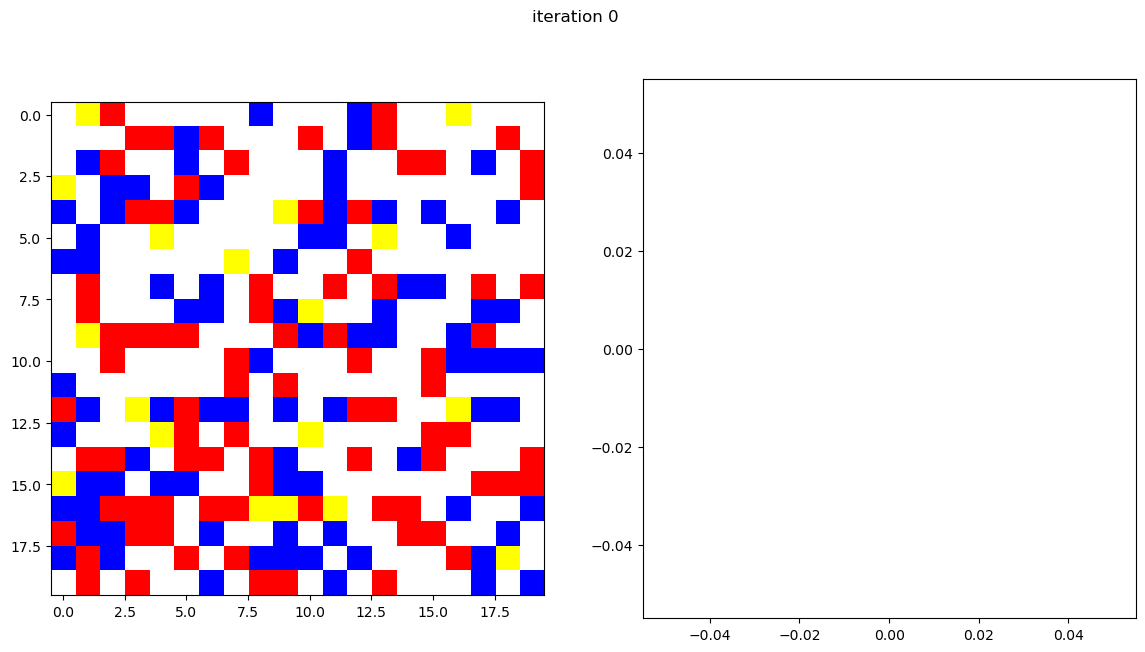

diversity ratio: 0.5732760863908405
diversity ratio: 0.5732760863908405
diversity ratio: 0.572456414259693
diversity ratio: 0.5634575569358178
diversity ratio: 0.5583398386677075
diversity ratio: 0.5555165235493105
diversity ratio: 0.5536039552432995
diversity ratio: 0.5486859224564142
diversity ratio: 0.5454072339318241
diversity ratio: 0.5364992150706436
diversity ratio: 0.5300889586603873
diversity ratio: 0.526019468560905
diversity ratio: 0.5274927650618259
diversity ratio: 0.5182846619310708
diversity ratio: 0.5157984740857668
diversity ratio: 0.5074191002367798
diversity ratio: 0.49616402116402114
diversity ratio: 0.4980047885075818
diversity ratio: 0.49916201117318443
diversity ratio: 0.49487895716946
diversity ratio: 0.4798689138576778
diversity ratio: 0.477621722846442
diversity ratio: 0.4762172284644195
diversity ratio: 0.47537453183520595
diversity ratio: 0.472565543071161
diversity ratio: 0.4631826741996233
diversity ratio: 0.46421845574387943
diversity ratio: 0.45790960451

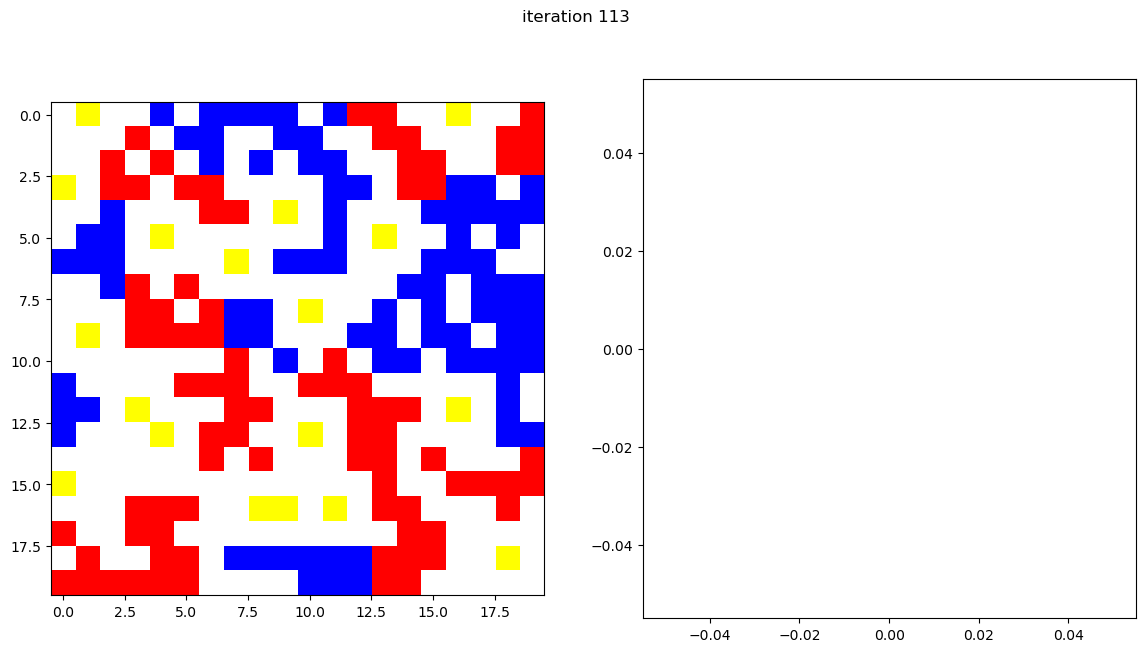

Finished running in 113 moves
Diversity is 0.09007707129094412


In [55]:
# Run the simulation
simulate_and_visualize(neighborhood, empty, active)